<a href="https://colab.research.google.com/github/sayanbanerjee32/paddy_comp_with_jhoward/blob/main/paddy_comp_tta_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

!pip install -Uq 'timm>=0.6.2.dev'
from fastkaggle import *

     |████████████████████████████████| 61 kB 3.1 MB/s 
     |████████████████████████████████| 497 kB 3.8 MB/s 


In [2]:
# import colab libraries
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_api_auth/kaggle.json ~/.kaggle/

In [4]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev"')

100%|██████████| 1.02G/1.02G [00:36<00:00, 29.9MB/s]


In [6]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train_images')]

In [7]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


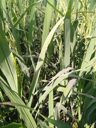

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [9]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

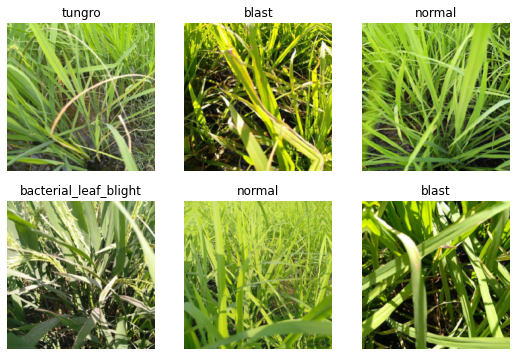

In [10]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)) # size 128 to 224

dls.show_batch(max_n=6)

In [11]:
import timm
timm.list_models("convnext*")

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano_hnf',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_hnfd',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [12]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate, path='.').to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


SuggestedLRs(valley=0.0005754399462603033, slide=0.0030199517495930195)

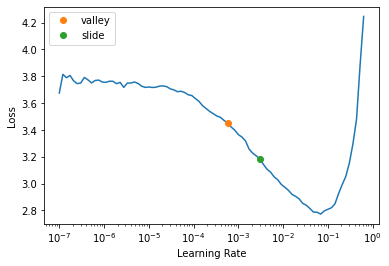

In [13]:
learn.lr_find(suggest_funcs=(valley, slide))

In [14]:
learn.fine_tune(12, 0.01) # learning rate increased to 0.01 and number of epochs to 12

epoch,train_loss,valid_loss,error_rate,time
0,1.235561,0.751767,0.219125,01:52


epoch,train_loss,valid_loss,error_rate,time
0,0.590048,0.340477,0.100432,02:14
1,0.407928,0.290338,0.081211,02:13
2,0.357442,0.275616,0.082653,02:15
3,0.296955,0.262298,0.066314,02:13
4,0.233127,0.182036,0.051418,02:13
5,0.174503,0.198812,0.049495,02:13
6,0.141747,0.162843,0.042768,02:13
7,0.102930,0.126551,0.028352,02:13
8,0.090278,0.109983,0.025949,02:13
9,0.058040,0.104254,0.024988,02:15


In [15]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)
error_rate(preds, targs)

TensorBase(0.0259)

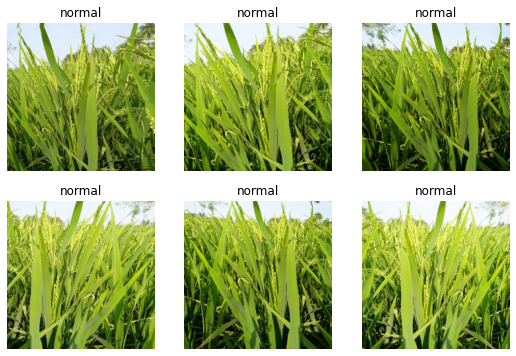

In [16]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [17]:
tta_preds,_ = learn.tta(dl=valid)
error_rate(tta_preds, targs)

TensorBase(0.0226)

### Larger images

In [28]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [29]:
trn_path = path/'train_images'
arch = 'convnext_small_in22k'

In [30]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.253684,0.878956,0.276309,02:19


epoch,train_loss,valid_loss,error_rate,time
0,0.598486,0.327836,0.102355,02:21
1,0.433348,0.334440,0.092744,02:13
2,0.384044,0.322389,0.093224,02:12
3,0.311326,0.238243,0.067756,02:12
4,0.238995,0.210325,0.061989,02:11
5,0.212644,0.178254,0.051898,02:12
6,0.142159,0.141308,0.034118,02:12
7,0.099008,0.148651,0.032196,02:13
8,0.080692,0.136077,0.030274,02:11
9,0.056626,0.109408,0.024507,02:11


In [31]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0240)

In [32]:
tta_preds,targs = learn.tta(dl=learn.dls.valid,use_max= True)
error_rate(tta_preds, targs)

TensorBase(0.0240)

### Submission

In [33]:
ss = pd.read_csv(path/'sample_submission.csv')
ss.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


In [34]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

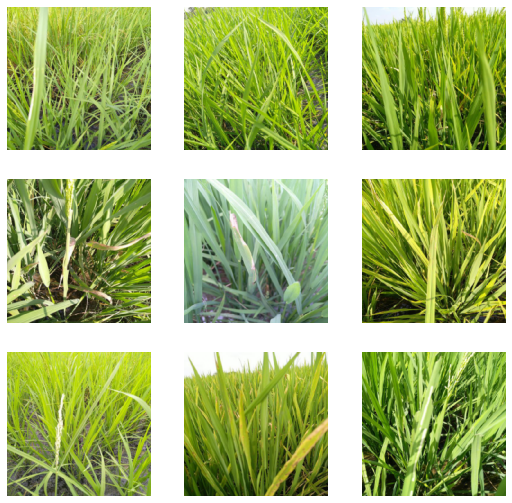

In [35]:
tst_dl.show_batch()

In [36]:
preds,_ = learn.tta(dl=tst_dl)
idxs = preds.argmax(dim=1)
idxs

TensorBase([7, 8, 3,  ..., 8, 1, 5])

In [37]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [38]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

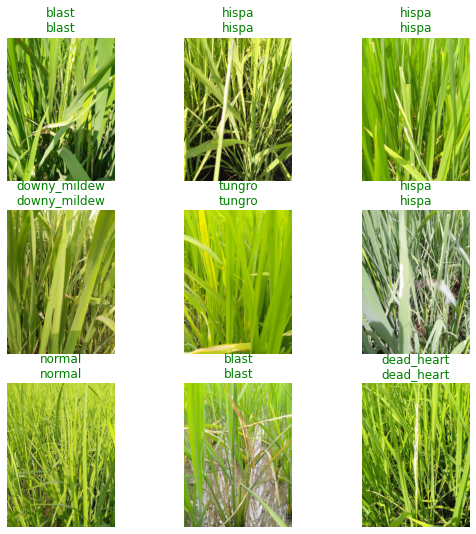

In [39]:
learn.show_results()

In [40]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [41]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'convnext_small 256x192 tta', comp)

100%|██████████| 70.5k/70.5k [00:03<00:00, 21.2kB/s]


In [ ]:
if not iskaggle:
    push_notebook('saan', 'paddy-initial-model',
                  title='Paddy initial model',
                  file='/content/drive/MyDrive/Colab Notebooks/paddy_comp_initial_model.ipynb',
                  competition=comp, private=True, gpu=True)

Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/saansd2003/paddy-initial-model
